## Модули

In [1]:
from zipfile import ZipFile
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import cv2
import albumentations as A
import tensorflow as tf
import keras
import keras.metrics
from keras.layers import Conv2D, MaxPool2D, Dropout, Conv2DTranspose, concatenate, Input
from keras.applications import ResNet50

## Константы

In [2]:
DIR = "."
TRAIN = "train"
TEST = "test"
IMAGES = "images"
MASKS = "masks"
MASKS_LABELED = "masks_labeled"

IMG_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 500

## Подготовка данных

In [3]:
# разархивируем данные
for data in ["train.zip", "test.zip"]:
    with ZipFile(os.path.join(DIR, data), "r") as zipfile:
        zipfile.extractall()

In [4]:
# кодировка цветов
PALETTE = {
    0: (60, 16, 152),  # Building
    1: (132, 41, 246),  # Land
    2: (110, 193, 228),  # Road
    3: (254, 221, 58),  # Vegetation
    4: (226, 169, 41),  # Water
    5: (155, 155, 155),  # Unlabeled
}


# перевод цветной маски в метки
def colors2labels(mask_colored, palette=PALETTE):
    mask_labeled = np.zeros(mask_colored.shape[:2]) - 1
    for label, color in palette.items():
        mask_labeled = np.where(
            (mask_colored == np.array(color)).all(axis=-1), label, mask_labeled
        )
    return mask_labeled.astype("int")


# перевод меток в цвета
def labels2colors(mask_labeled, palette=PALETTE):
    mask_colored = np.zeros(mask_labeled.shape + (3,))
    for label, color in palette.items():
        mask_colored = np.where(
            np.expand_dims(label == mask_labeled, axis=-1),
            np.array(color),
            mask_colored,
        )
    return mask_colored.astype("int")

Переведем одну из масок в метки.

In [5]:
mask_colored = cv2.cvtColor(
    cv2.imread(os.path.join(DIR, TRAIN, MASKS, "0.png")), cv2.COLOR_BGR2RGB
)
mask_labeled = colors2labels(mask_colored)
np.unique(mask_labeled)

array([-1,  0,  1,  2,  3,  4,  5])

Можно видеть, что некоторые цвета конвертировались некорректно (отображается как -1), т.к. их не было в таблице конвертации.

Напишем функцию для корректировки меток, она будет брать значения некорректно конфертированных цветов и находить ближайший для них в таблице конвертации по максимуму скалярного произведения.

In [6]:
# корректировка меток
def correct_labels(mask_labeled, mask_colored, target=-1, palette=PALETTE):
    palette_colors = np.array([color for color in palette.values()])
    mask_labeled_corrected = np.copy(mask_labeled)
    # индексы, где маска равна target
    target_indices = np.where(mask_labeled_corrected == target)
    # вычисляем скалярное произведение
    dot_products = np.dot(mask_colored[target_indices], palette_colors.transpose())
    # обновляем маску
    mask_labeled_corrected[target_indices] = np.argmax(dot_products, axis=1)
    return mask_labeled_corrected

In [7]:
mask_labeled_corrected = correct_labels(mask_labeled, mask_colored)
np.unique(mask_labeled_corrected)

array([0, 1, 2, 3, 4, 5])

После применения функции некорректные метки отсутствуют.

Визуализируем результаты.

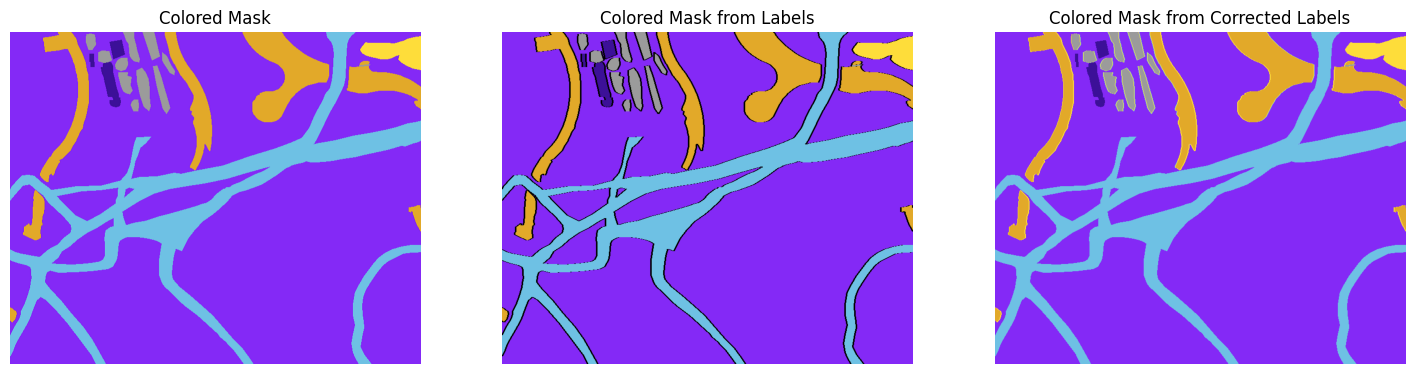

In [8]:
mask_colored_from_labeled = labels2colors(mask_labeled)
mask_colored_corrected = labels2colors(mask_labeled_corrected)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for i, (mask, title) in enumerate(
    zip(
        [mask_colored, mask_colored_from_labeled, mask_colored_corrected],
        [
            "Colored Mask",
            "Colored Mask from Labels",
            "Colored Mask from Corrected Labels",
        ],
    )
):
    ax[i].imshow(mask)
    ax[i].set_title(title)
    ax[i].axis("off")

На рисунке по середине можно видеть, что в метки некорректно переводятся пиксели, находящиеся на границе между разными объектами, вероятно, это связано с наложением цветов друг на друга. После корректировки меток данная проблема отсутствует.

Сохраним маски с метками в файлы для дальнейшего использования.

In [9]:
def save_masks_labeled(mask_colored_path, mask_labeled_path):
    os.makedirs(mask_labeled_path, exist_ok=True)

    for mask in [
        fname for fname in os.listdir(mask_colored_path) if fname.endswith(".png")
    ]:
        mask_colored = cv2.cvtColor(
            cv2.imread(os.path.join(mask_colored_path, mask)), cv2.COLOR_BGR2RGB
        )
        mask_labeled = colors2labels(mask_colored)
        mask_labeled = correct_labels(mask_labeled, mask_colored)
        cv2.imwrite(os.path.join(mask_labeled_path, mask), mask_labeled)

In [10]:
for path in [TRAIN, TEST]:
    save_masks_labeled(
        os.path.join(DIR, path, MASKS), os.path.join(DIR, path, MASKS_LABELED)
    )

Проверим результат.

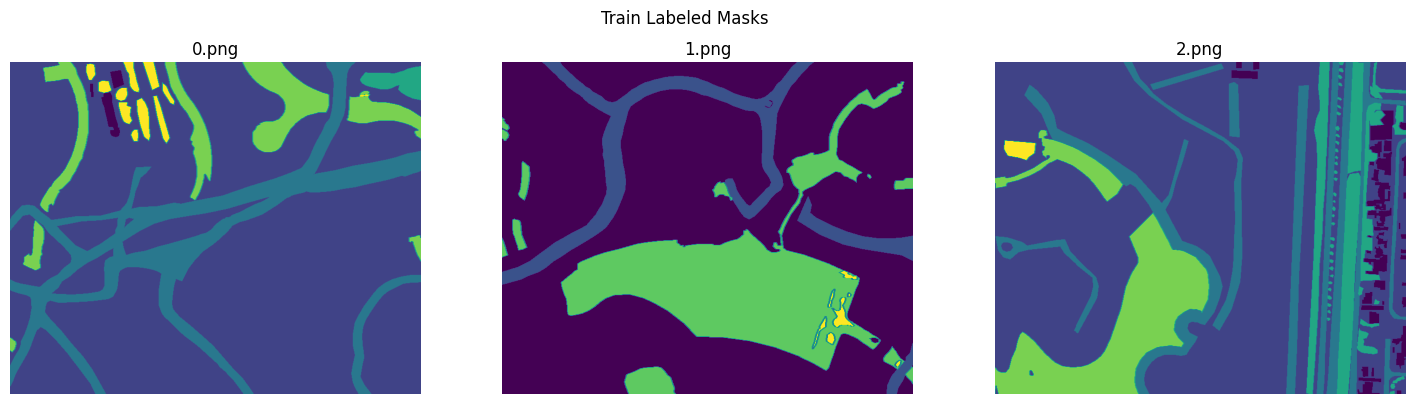

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig.suptitle("Train Labeled Masks", y=0.86)
for i, fname in enumerate(os.listdir(os.path.join(DIR, TRAIN, MASKS_LABELED))[:3]):
    mask = cv2.imread(
        os.path.join(os.path.join(DIR, TRAIN, MASKS_LABELED, fname)), cv2.COLOR_BGR2GRAY
    )
    ax[i].imshow(mask)
    ax[i].set_title(fname)
    ax[i].axis("off")

Артефакты по краям объектов отсутствуют, цвета конвертированы в метки корректно.

## Загрузка и аугментация данных

Функции для загрузки и аугментации.

In [12]:
def get_dataset(
    img_paths,
    mask_paths,
    img_size,
    batch_size,
    augment_transforms=None,
    shuffle=False,
):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.shuffle(buffer_size=len(img_paths)) if shuffle else dataset
    dataset = dataset.map(
        partial(
            load_images_masks,
            img_size=img_size,
            augment_transforms=augment_transforms,
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    ).prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = (
        dataset.map(
            partial(set_shapes, img_size=img_size), num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    return dataset


def load_images_masks(img_path, mask_path, img_size, augment_transforms):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.image.convert_image_dtype(img, "float32")
    img /= tf.math.reduce_max(img)

    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size, method="nearest")
    mask = tf.image.convert_image_dtype(mask, "uint8")

    if augment_transforms:
        img, mask = tf.numpy_function(
            partial(augment_data, augment_transforms=augment_transforms),
            inp=[img, mask],
            Tout=[tf.float32, tf.uint8],
        )
    return img, mask


def augment_data(img, mask, augment_transforms):
    data_augmented = augment_transforms(image=img, mask=mask)
    return data_augmented["image"], data_augmented["mask"]


# после применения tf.numpy_function() тензоры теряют информацию о размере
# восстановим эту информацию
def set_shapes(img, mask, img_size):
    img.set_shape(img_size + (3,))
    mask.set_shape(img_size + (1,))
    return img, mask


def get_paths(dir, folder, data):
    return sorted(
        [
            os.path.join(dir, folder, data, item)
            for item in os.listdir(os.path.join(dir, folder, data))
        ]
    )

Набор аугментационных преобразований.

In [13]:
AUGMENT_TRANSFORMS = A.Compose(
    [
        # выделение случайного участка
        A.RandomCrop(height=112, width=112, p=0.5),
        # восстановление исходного размера (на случай если сработал RandomCrop)
        A.Resize(*IMG_SIZE, interpolation=cv2.INTER_NEAREST),
        # горизонтальное отражение
        A.HorizontalFlip(p=0.5),
        # вертикальное отражение
        A.VerticalFlip(p=0.5),
        # случайное вращение
        A.RandomRotate90(p=0.5),
        # случайное изменение яркости и контрастности
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        # изменение оттенка, насыщенности и яркости
        A.HueSaturationValue(
            hue_shift_limit=0.1, sat_shift_limit=0.1, val_shift_limit=0.1, p=0.5
        ),
        # смещение, масштабирование и поворот
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
        # добавление шума
        A.GaussNoise(var_limit=0.04, p=0.2),
        # добавление размытия в движении
        A.MotionBlur(p=0.5),
        # изменение перспективы
        A.Perspective(p=0.5),
    ]
)

Обучающий и тестовый наборы данных.

In [14]:
train_ds = get_dataset(
    get_paths(DIR, TRAIN, IMAGES),
    get_paths(DIR, TRAIN, MASKS_LABELED),
    IMG_SIZE,
    BATCH_SIZE,
    augment_transforms=AUGMENT_TRANSFORMS,
    shuffle=True,
)

test_ds = get_dataset(
    get_paths(DIR, TEST, IMAGES),
    get_paths(DIR, TEST, MASKS_LABELED),
    IMG_SIZE,
    BATCH_SIZE,
)

Просмотр данных, выдаваемых загрузчиком.

Train data: images.shape = (7, 224, 224, 3), masks.shape = (7, 224, 224, 1)
Unique values in masks: [0 1 2 3 4 5]


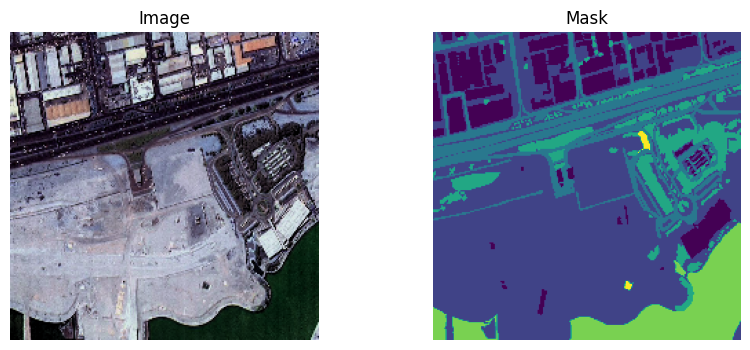

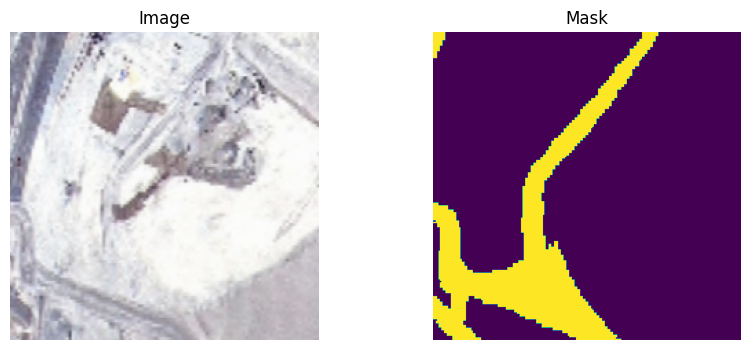

In [15]:
# обучающие данные с аугментацией
for images, masks in train_ds.take(1):
    print(f"Train data: images.shape = {images.shape}, masks.shape = {masks.shape}")
    print(f"Unique values in masks: {np.unique(masks.numpy())}")

for i in range(2):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ax[0].imshow(images[i].numpy())
    ax[0].set_title("Image")
    ax[0].axis("off")
    ax[1].imshow(masks[i].numpy())
    ax[1].set_title("Mask")
    ax[1].axis("off")
    plt.show()

Test data: images.shape = (2, 224, 224, 3), masks.shape = (2, 224, 224, 1)
Unique values in masks: [0 1 2 3 4 5]


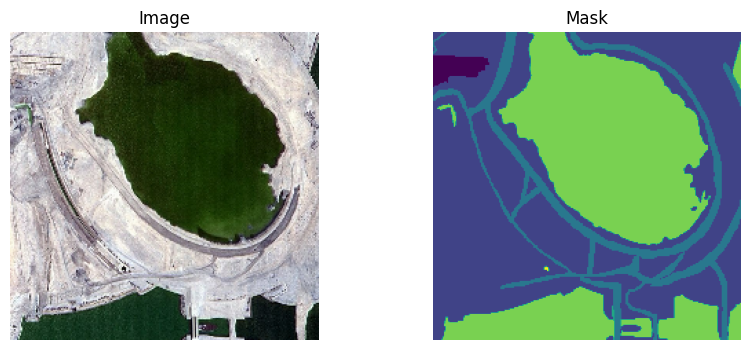

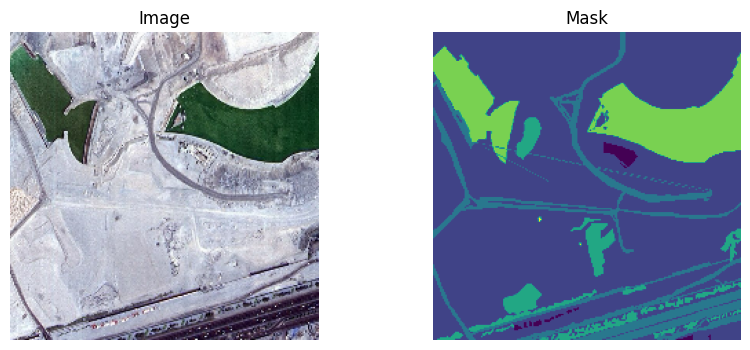

In [16]:
# тестовые данные без аугментации
for images, masks in test_ds.take(1):
    print(f"Test data: images.shape = {images.shape}, masks.shape = {masks.shape}")
    print(f"Unique values in masks: {np.unique(masks.numpy())}")

for i in range(2):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ax[0].imshow(images[i].numpy())
    ax[0].set_title("Image")
    ax[0].axis("off")
    ax[1].imshow(masks[i].numpy())
    ax[1].set_title("Mask")
    ax[1].axis("off")
    plt.show()

## Обучение сегментационных моделей

### U-Net с нуля

In [17]:
def Conv2DDouble(x, n_filters):
    x = Conv2D(n_filters, 3, padding="same", activation="relu")(x)
    x = Conv2D(n_filters, 3, padding="same", activation="relu")(x)
    return x


def downsample_block(x, n_filters):
    f = Conv2DDouble(x, n_filters)
    p = MaxPool2D(2)(f)
    p = Dropout(0.3)(p)
    return f, p


def upsample_block(x, conv_features, n_filters):
    x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = concatenate([x, conv_features])
    x = Dropout(0.3)(x)
    x = Conv2DDouble(x, n_filters)
    return x


def get_unet_vanilla(num_classes, input_shape=IMG_SIZE + (3,)):
    inputs = Input(shape=input_shape)

    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    bottleneck = Conv2DDouble(p4, 1024)

    u1 = upsample_block(bottleneck, f4, 512)
    u2 = upsample_block(u1, f3, 256)
    u3 = upsample_block(u2, f2, 128)
    u4 = upsample_block(u3, f1, 64)

    outputs = Conv2D(num_classes, 3, padding="same", activation="softmax")(u4)
    return keras.Model(inputs, outputs, name="U-net")

In [18]:
unet_vanilla = get_unet_vanilla(len(PALETTE))
unet_vanilla.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.MeanIoU(len(PALETTE), "MeanIoU", sparse_y_pred=False),
    ],
)
unet_vanilla.summary()

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [19]:
FIT_UNET_VANILLA = False
if FIT_UNET_VANILLA:
    history_unet_vanilla = unet_vanilla.fit(
        train_ds,
        validation_data=test_ds,
        epochs=EPOCHS,
        callbacks=[
            keras.callbacks.ModelCheckpoint(
                "./unet_vanilla.h5",
                monitor="val_accuracy",
                save_best_only=True,
                verbose=1,
            )
        ],
    )

    with open("./history_unet_vanilla.json", "w") as file:
        json.dump(history_unet_vanilla.history, file)

In [20]:
with open("./history_unet_vanilla.json", "r") as file:
    history_unet_vanilla = json.load(file)

unet_vanilla = keras.models.load_model("./unet_vanilla.h5")
unet_vanilla_metrics = unet_vanilla.evaluate(test_ds, verbose=0)

print(f"test_accuracy = {unet_vanilla_metrics[1]:.2f}")
print(f"test_MeanIoU = {unet_vanilla_metrics[2]:.2f}")

test_accuracy = 0.86
test_MeanIoU = 0.32


С помощью обученной модели U-net достигается величина Accuracy, равная 86%, что соответствует требованиям задачи. Низкое значение IoU, равное 32% может говорить о том, что модель с низкой точностью предсказывает объекты малых размеров.

Отобразим историю обучения модели.

In [21]:
# Отображение истории обучения
def show_history(
    history_dict,
    comment_txt=None,
    accuracy_target=None,
    accuracy_ylims=(None, None),
    loss_ylims=(None, None),
):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    fig.suptitle(f"{comment_txt}")

    axs[0].plot(history_dict["accuracy"])
    axs[0].plot(history_dict["val_accuracy"])
    axs[0].hlines(
        accuracy_target,
        0,
        len(history_dict["val_accuracy"]),
        color="r",
        ls="--",
    )
    # Отметка максимума val_accuracy стрелкой
    max_acc = max(history_dict["val_accuracy"])
    epoch = np.argmax(history_dict["val_accuracy"])
    axs[0].annotate(
        f"max_accuracy = {max_acc:.2f}, Epoch {epoch + 1}/{len(history_dict['val_accuracy'])}",
        xy=(epoch, max_acc),
        xytext=(epoch - int(epoch / 1.8), max_acc - max_acc / 3),
        arrowprops={"color": "r", "arrowstyle": "->"},
    )
    axs[0].set_title("Model Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylim(*accuracy_ylims)
    axs[0].legend(["train", "test", "accuracy target"], loc="lower right")

    axs[1].plot(history_dict["loss"])
    axs[1].plot(history_dict["val_loss"])
    axs[1].set_title("Model Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylim(*loss_ylims)
    axs[1].legend(["train", "test"], loc="upper right")

    plt.show()

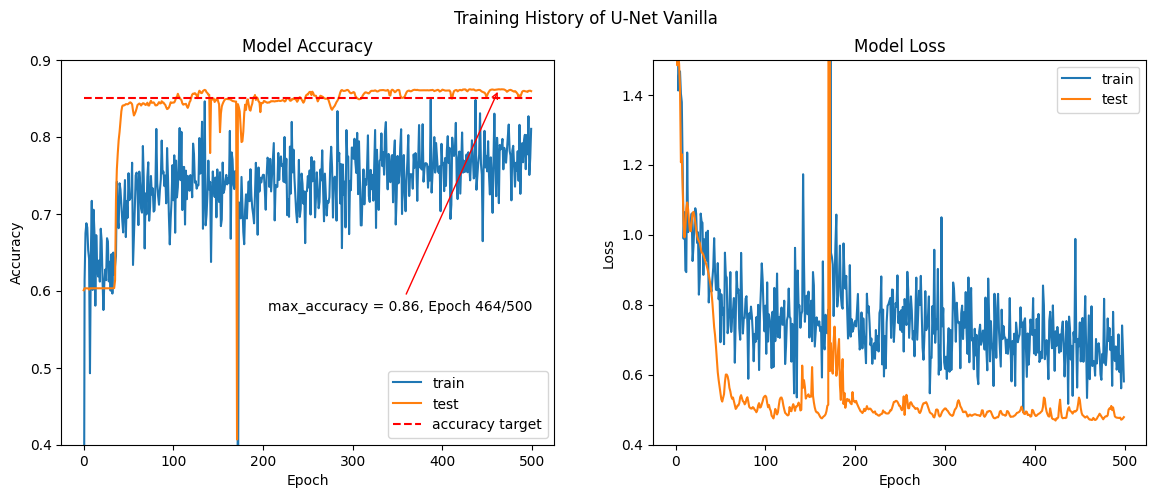

In [22]:
show_history(
    history_unet_vanilla,
    "Training History of U-Net Vanilla",
    accuracy_target=0.85,
    accuracy_ylims=(0.4, 0.9),
    loss_ylims=(0.4, 1.5),
)

Судя по графикам истории обучения, модель выглядит недообученной из-за малого количества обучающих данных. Выбросы на графиках, в районе 180 эпохи могут говорить о взрыве градиента и свидетельствуют о нестабильности процесса обучения до 200 эпохи.

Отобразим результаты предсказания модели вместе с исходным изображением и маской.

In [23]:
def show_imgs_masks_preds(tf_dataset, tf_model):
    imgs = [img.numpy() for batch, _ in tf_dataset for img in batch]
    masks = [mask.numpy() for _, batch in tf_dataset for mask in batch]
    preds = [
        np.expand_dims(np.argmax(item, axis=-1), axis=-1)
        for item in tf_model.predict(tf_dataset, verbose=0)
    ]

    for items in zip(imgs, masks, preds):
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
        for i, (item, title) in enumerate(zip(items, ["Image", "Mask", "Prediction"])):
            ax[i].imshow(item)
            ax[i].set_title(title)
            ax[i].axis("off")
        plt.show()

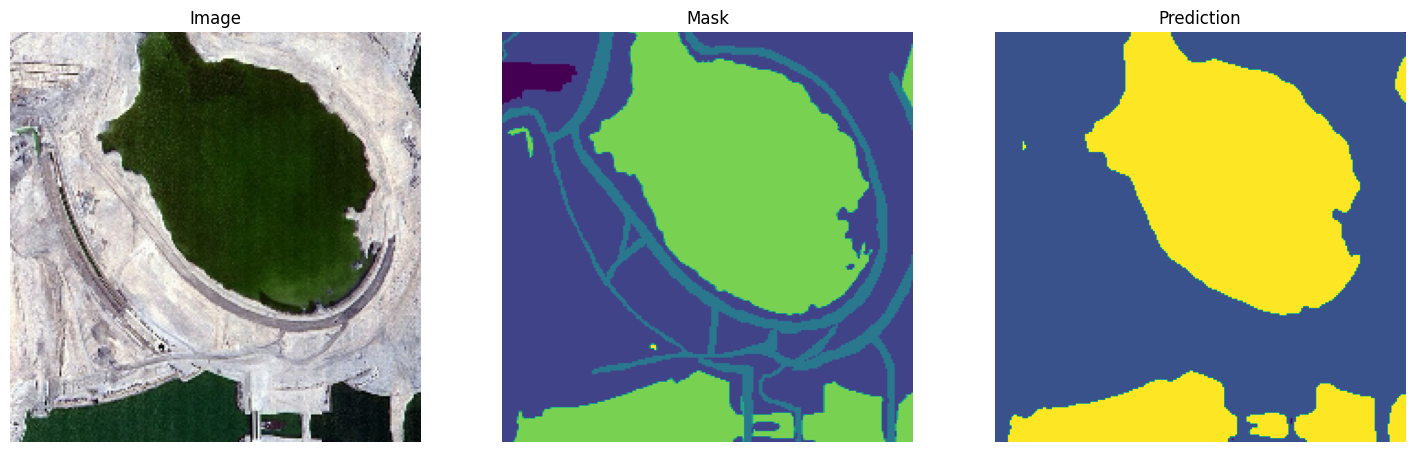

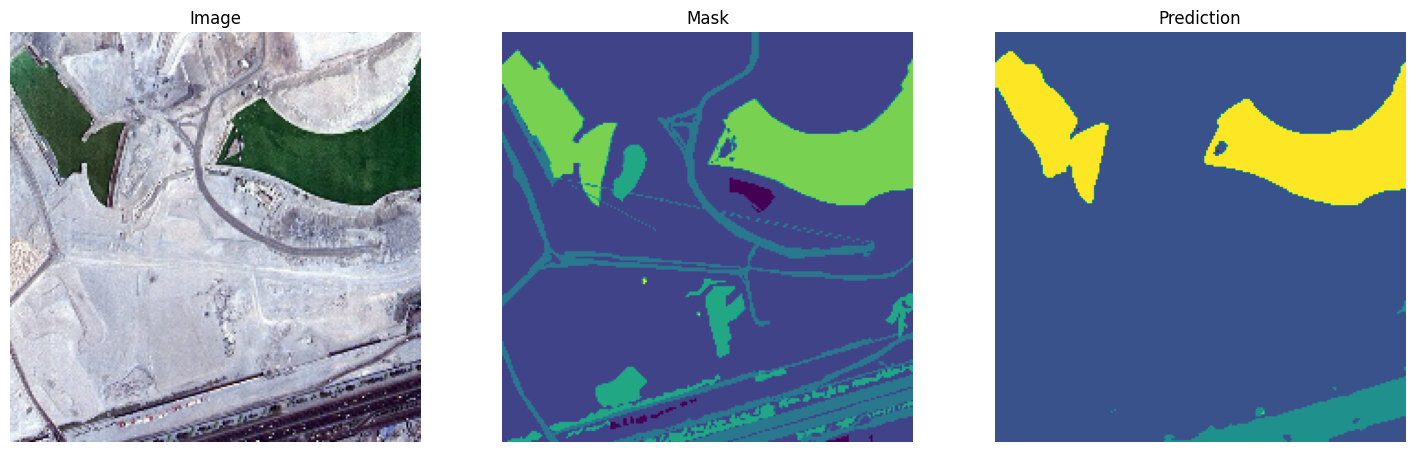

In [24]:
show_imgs_masks_preds(test_ds, unet_vanilla)

На рисунке можно видеть, что модель предсказывает, главным образом, крупные объекты - землю, водоемы и крупные дороги. По этой причине достигается низкое значение метрики IoU.

### U-Net с предобученным энкодером

Создадим сегментационную модель с предобученным энкодером.

In [25]:
def get_unet_resnet_encoder(num_classes, input_shape=IMG_SIZE + (3,)):
    inputs = Input(shape=input_shape, name="input1")

    # загружаем предобученную ResNet50 в качестве энкодера
    base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

    # заморозка весов энкодера
    base_model.trainable = False

    # извлекаем блоки из ResNet для подключения к декодеру
    skip_connections = [
        base_model.get_layer("conv1_relu").output,  # (None, 112, 112, 64)
        base_model.get_layer("conv2_block3_out").output,  # (None, 56, 56, 256)
        base_model.get_layer("conv3_block4_out").output,  # (None, 28, 28, 512)
        base_model.get_layer("conv4_block6_out").output,  # (None, 14, 14, 1024)
    ]
    skip_connections.reverse()

    # bottleneck
    x = base_model.get_layer("conv5_block3_out").output  # (None, 7, 7, 2048)

    # декодер
    for conv_features in skip_connections:
        x = upsample_block(x, conv_features, conv_features.shape[-1])

    # декодерный блок для восстановления исходного разрешения
    conv_features = base_model.get_layer("input1").output  # (None, 224, 224, 3)
    conv_features = Conv2DDouble(conv_features, 32)  # (None, 224, 224, 32)
    x = upsample_block(x, conv_features, 32)

    # выходной слой
    outputs = Conv2D(num_classes, 3, padding="same", activation="softmax")(x)
    return keras.Model(inputs, outputs, name="U-netResNetEncoder")

In [26]:
unet_resnet_encoder = get_unet_resnet_encoder(len(PALETTE))
unet_resnet_encoder.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.MeanIoU(len(PALETTE), "MeanIoU", sparse_y_pred=False),
    ],
)
unet_resnet_encoder.summary()

Model: "U-netResNetEncoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input1[0][0]']                 
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                 

In [27]:
FIT_UNET_RESNET_ENCODER = False
if FIT_UNET_RESNET_ENCODER:
    history_unet_resnet_encoder = unet_resnet_encoder.fit(
        train_ds,
        validation_data=test_ds,
        epochs=EPOCHS,
        callbacks=[
            keras.callbacks.ModelCheckpoint(
                "./unet_resnet_encoder.h5",
                monitor="val_accuracy",
                save_best_only=True,
                verbose=1,
            )
        ],
    )

    with open("./history_unet_resnet_encoder.json", "w") as file:
        json.dump(history_unet_resnet_encoder.history, file)

In [28]:
with open("./history_unet_resnet_encoder.json", "r") as file:
    history_unet_resnet_encoder = json.load(file)

unet_resnet_encoder = keras.models.load_model("./unet_resnet_encoder.h5")
unet_resnet_encoder_metrics = unet_resnet_encoder.evaluate(test_ds, verbose=0)

print(f"test_accuracy = {unet_resnet_encoder_metrics[1]:.2f}")
print(f"test_MeanIoU = {unet_resnet_encoder_metrics[2]:.2f}")

test_accuracy = 0.86
test_MeanIoU = 0.33


Благодаря модели, с предобученным энкодером, достигается значение метрики Accuracy, равное метрике стандартной модели (86%), однако MeanIoU превосходит таковую, достигнутую ранее. Это может свидетельствовать о том, что модель с более высокой точностью способна предсказывать относительно мелкие объекты.

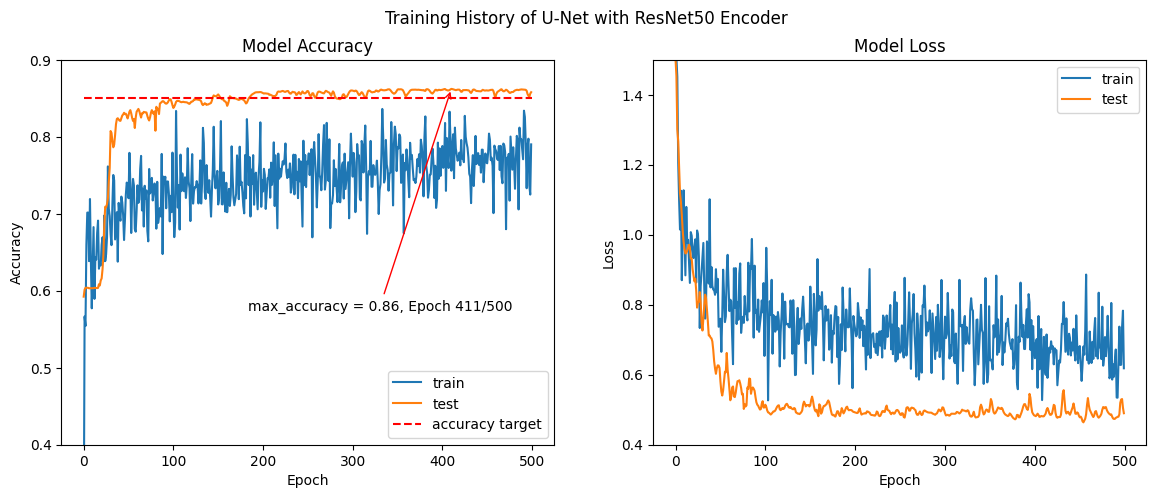

In [29]:
show_history(
    history_unet_resnet_encoder,
    "Training History of U-Net with ResNet50 Encoder",
    accuracy_target=0.85,
    accuracy_ylims=(0.4, 0.9),
    loss_ylims=(0.4, 1.5),
)

Также как и в случае выше, модель кажется недообученной из-за ограниченности набора обучающих данных. Можно заметить, что на кривых обучения отсутвуют выбросы, замеченные ранее - это свидетельствует о более стабильном протекании процесса обучения.

Отобразим результаты предсказания.

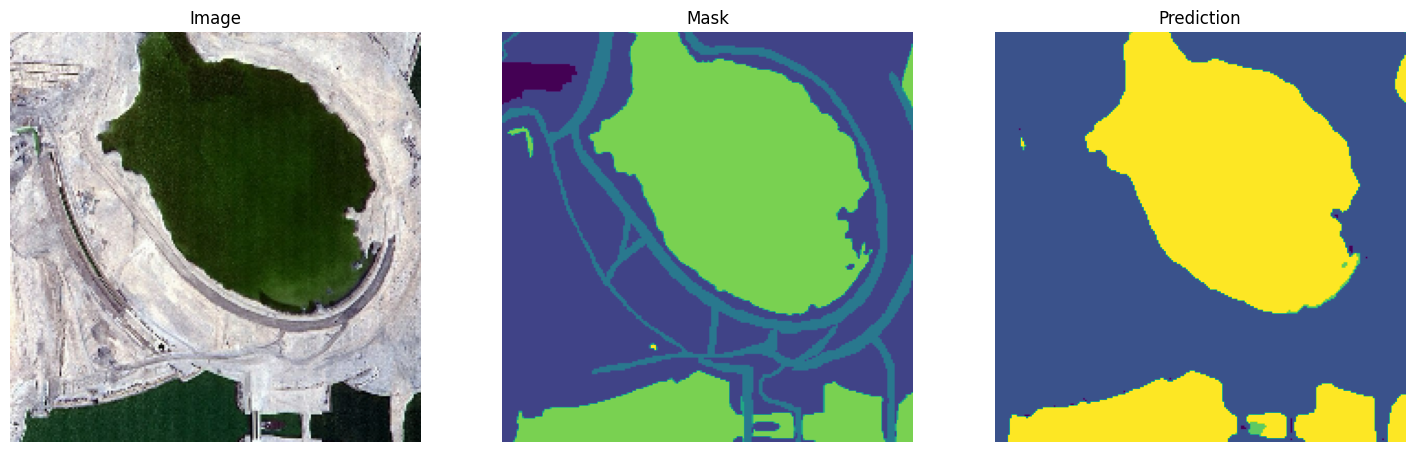

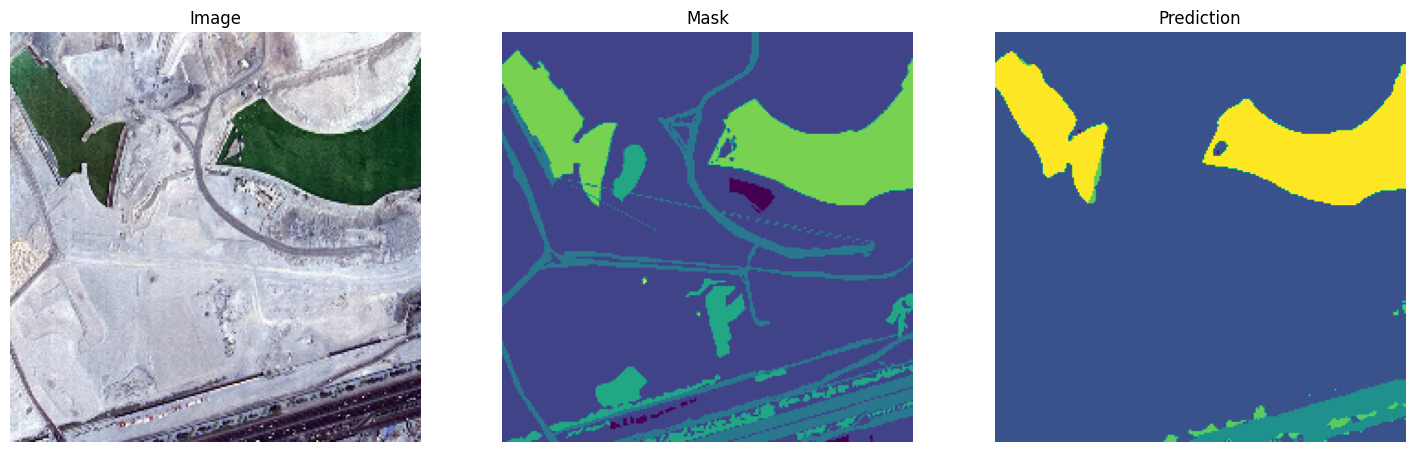

In [30]:
show_imgs_masks_preds(test_ds, unet_resnet_encoder)

Предскакзания модели схожи с полученными ранее, но помимо крупных объектов модель также может предсказывать более мелкие - некоторые деревья, растущие вдоль дороги.

## Выводы

- В работе подготовлены две сегментационные модели на основе архитектуры U-net для определения элементов ландшафта на спутниковых снимках. Одна из них обучена послностью с нуля, а вторая содержит предобученных энкодер (ResNet50). 
- С помощью обеих моделей удалось добиться метрики Accuracy равной 86% на тестовом наборе данных, что соответствует условиям задачи.
- Полученные модели в основном определяют крупные элементы ландшафта: почву, водоемы, крупные дороги. Эта особенность связана с низким количеством обучающих данных.
- Показано, что модель с предобученным энкодером обладает немного большей величиной метрики MeanIoU и помимо крупных объектов также способна определять некоторые мелкие такие, как деревья. Однако данная модель, обладает большим количеством параметров и медленнее обучается, а также медленнее выдает предсказания.